<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

sfrerich

Aim: Preprocess annotated mouse brain single-cell data from Zeisel et al 2018 (160k cells stored as loom file)

In [1]:
import sys
import os, fnmatch 

In [2]:
import anndata
import scanpy as sc
import scipy as sci
#sc.logging.print_versions()

In [3]:
sc.settings.verbosity = 3

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [5]:
from datetime import date
from matplotlib.pyplot import rc_context

In [6]:
os.getcwd()

'\\\\isdsynnas.srv.med.uni-muenchen.de\\BD-Dichgans\\SF\\Git\\p6\\foxf2-per-celltype'

In [7]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

# Load + format data

## Annotated by authors

Code gratefully partly based on https://github.com/theislab/scib-reproducibility/blob/main/notebooks/data_preprocessing/mouse_brain/01_collect_mouse_brain_studies.ipynb

(see SF/P6_vasc_scRNAseq/DropViz/all_by_region/)

Data downloaded from: http://mousebrain.org/adolescent/downloads.html

In [ ]:
adata_zeisel = sc.read_loom(main_dir+"/P6_vasc_scRNAseq/Zeisel2018/l5_all.loom")

In [ ]:
adata_zeisel.obs_names_make_unique()
adata_zeisel.var_names_make_unique()

In [ ]:
adata_zeisel

In [ ]:
list(adata_zeisel.obs.columns)

In [ ]:
pd.value_counts(adata_zeisel.obs['Class'])

In [ ]:
pd.value_counts(adata_zeisel.obs['Taxonomy_group'])

In [ ]:
adata_zeisel.obs['Region'].astype('category').cat.categories

In [ ]:
pd.value_counts(adata_zeisel.obs['Age'])

In [ ]:
pd.value_counts(adata_zeisel.obs['Subclass'])

Assign regions to the already present brain structures:
* Amygdala - Amygdala (AMY)
* CA1 - Hippocampus (HC)
* Ctx1, Ctx1.5, Ctx2, Ctx3 - Cortex (CTX)
* DRG - Dorsal root ganglia (**to exclude**)
* DentGyr - Dentate Gyrus (to Hippocampus)
* ENS - Enteric nervous system (**to exclude**)
* HC - Hippocampus
* Hypoth - Hypothalamus (HTH)
* MBd, MBv - midbrain dorsal, ventral (merge to midbrain, MB)
* Medulla - MD
* OB - olfactory bulb
* Pons - PO 
* SC - spinal cord  (**to exclude**)
* SScortex - secondary somatosensensory cortex - Cortex (CTX)
* StriatDor, StriatVent - Striatum (STR)
* Sympath - Sympathetic ganglion (**to exclude**)
* Thal - Thalamus (TH)

In [ ]:
adata_zeisel.obs['Tissue'].astype('category').cat.categories

In [ ]:
region_dict = dict({'Amygd': 'AMY', 
                    'CA1' : 'HC', 
                    'Ctx1': 'CTX', 
                    'Ctx1.5': 'CTX', 
                    'Ctx2': 'CTX', 
                    'Ctx3': 'CTX', 
                    #'DRG',
                    'DentGyr' : 'HC', 
                    #'ENS', 
                    'Hypoth' : 'HTH', 
                    'MBd' : 'MB', 
                    'MBv' : 'MB', 
                    'Medulla' : 'MD', 
                    'Pons' : 'PO',
                    'SScortex' : 'CTX', 
                    'StriatDor' : 'STR', 
                    'StriatVent': 'STR',
                    #'Sympath', 
                    'Thal' : 'TH'})

df = pd.DataFrame.from_dict(region_dict, orient='index')

In [ ]:
adata_zeisel.obs['region'] = adata_zeisel.obs['Tissue'].astype('category').cat.add_categories(np.unique(
        ['AMY', 'CTX', 'HTH', 'MB', 'MD', 'PO', 'STR', 'TH']))

for idx in enumerate(df[0]):
    adata_zeisel.obs['region'].loc[adata_zeisel.obs['region']==df[0].index[idx[0]]] = idx[1]
    
adata_zeisel.obs['region'] = adata_zeisel.obs['region'].astype('category').cat.remove_unused_categories()

Exclude `DRG`, `ENS` and `Sympath` cells.  
= all peripheral NS cells

In [ ]:
adata_zeisel = adata_zeisel[np.invert(np.in1d(adata_zeisel.obs['region'], ['DRG', 'ENS', 'Sympath','SC']))].copy() # remove SC because only interested in brain

In [ ]:
adata_zeisel = adata_zeisel[np.invert(np.in1d(adata_zeisel.obs['Taxonomy_group'], ['Spinal cord excitatory neurons', 'Spinal cord inhibitory neurons']))].copy() # remove SC neurons

In [ ]:
adata_zeisel.obs['region'].value_counts()

In [ ]:
pd.value_counts(adata_zeisel.obs['Subclass'])

In [ ]:
pd.value_counts(adata_zeisel.obs['Age'])

In [ ]:
pd.value_counts(adata_zeisel.obs['Sex'])

In [ ]:
pd.value_counts(adata_zeisel.obs['DonorID'])

In [ ]:
pd.crosstab(adata_zeisel.obs['Taxonomy_group'],adata_zeisel.obs['Subclass'])

In [ ]:
adata_zeisel

In [ ]:
del adata_zeisel.obs['Region']

Scib re-grouped cell types as in the following. I did re-grouping myself, based on cell types of interest.

<s>Let us use the `Taxonomy_group` of `adata_zeisel` as a new variable `cell_type`. Then, *oligos* are renamed to *oligodendrocytes*, *vascular* becomes *endothelial cell*. The *Immune* cells are a mixture of *macrophages* and *microglia*. We have to check the *Peripheral glia* and *Ependymal*, which have no correspondence in the other datasets. However, microglia are apparently missing in the dataset.</s>

In [ ]:
sc.pl.violin(adata_zeisel, ['Lyz2', 'Ctss', 'Cd74'], groupby='Taxonomy_group')

**Conclusion** Peripheral Glia have most overlap with brain pericytes and we keep the ependymal cells as extra category.

In [ ]:
adata_zeisel.obs['Taxonomy_group'].cat.categories

In [ ]:
# # from scib code (not used)
# adata_zeisel.obs['cell_type'] = adata_zeisel.obs['Taxonomy_group'].cat.add_categories(['astrocyte', 
#         'brain pericyte', 'endothelial cell','ependymal cell','neuron',
#        'macrophage', 'microglial cell', 'oligodendrocyte',
#                      'oligodendrocyte precursor cell',
#                          'olfactory ensheathing cell', ])

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Astrocytes','Subventricular zone radial glia-like cells',
#                                      'Dentate gyrus radial glia-like cells'])] =  'astrocyte'
# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Ependymal cells', 
#                                       'Subcommissural organ hypendymal cells'])] = 'ependymal cell'
         
# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Perivascular macrophages'])] = 'macrophage'
# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Microglia'])] = 'microglial cell'
           
# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Telencephalon inhibitory interneurons',
#        'Telencephalon projecting excitatory neurons',
#        'Telencephalon projecting inhibitory neurons', 
#                                       'Di- and mesencephalon excitatory neurons',
#        'Di- and mesencephalon inhibitory neurons',
#                                       'Cerebellum neurons',
#        'Cholinergic and monoaminergic neurons',
#                                       'Dentate gyrus granule neurons',
#                                       'Non-glutamatergic neuroblasts',
#                                       'Glutamatergic neuroblasts', 'Hindbrain neurons',
#                                       'Spinal cord excitatory neurons',
#                                       'Olfactory inhibitory neurons',
#                                       'Peptidergic neurons',
#        'Spinal cord inhibitory neurons'])] = 'neuron'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Oligodendrocytes'])] = 'oligodendrocyte'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Oligodendrocyte precursor cells'])] = 'oligodendrocyte precursor cell'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Olfactory ensheathing cells'])] = 'olfactory ensheathing cell'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Pericytes'])] = 'brain pericyte'

# adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
#                                      ['Vascular and leptomeningeal cells', 'Vascular endothelial cells',
#        'Vascular smooth muscle cells', 'Choroid epithelial cells'])] = 'endothelial cell'

# adata_zeisel.obs['cell_type'] = adata_zeisel.obs['cell_type'].cat.remove_unused_categories()


In [ ]:
# updated own (used)
adata_zeisel.obs['cell_type'] = adata_zeisel.obs['Taxonomy_group'].cat.add_categories(
        ['astrocytes','pericytes', 'Endothelial cells','Ependymal cell','Neurons','Neuroblasts',
        'Microglia/Macrophages', 'Oligos','SMCs', 'OPCs','olfactory ensheathing cells', 'Leptomeningeal cells']) # cannot be same name as "Taxonomy_group"

In [ ]:
list(adata_zeisel.obs['Taxonomy_group'].unique())

In [ ]:
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Astrocytes','Subventricular zone radial glia-like cells',
                                     'Dentate gyrus radial glia-like cells'])] =  'Astrocytes'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Ependymal cells','Subcommissural organ hypendymal cells', 'Choroid epithelial cells'])] = 'Ependymal cells'
         
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Microglia','Perivascular macrophages'])] = 'Microglia/Macrophages'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     [ 'Cholinergic and monoaminergic neurons','Telencephalon projecting excitatory neurons','Telencephalon inhibitory interneurons',
                                      'Olfactory inhibitory neurons','Peptidergic neurons','Di- and mesencephalon excitatory neurons','Hindbrain neurons',
                                      'Telencephalon projecting inhibitory neurons','Dentate gyrus granule neurons','Cerebellum neurons',
                                      'Di- and mesencephalon inhibitory neurons'])] = 'Neurons'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Glutamatergic neuroblasts',
                                      'Non-glutamatergic neuroblasts'])] = 'Neuroblasts'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Oligodendrocytes'])] = 'Oligos'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Oligodendrocyte precursor cells'])] = 'OPCs'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Olfactory ensheathing cells'])] = 'Olfactory ensheathing cells'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Pericytes'])] = 'Pericytes'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Vascular endothelial cells'])] = 'Endothelial cells'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Vascular smooth muscle cells'])] = 'SMCs'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Vascular and leptomeningeal cells'])] = 'Leptomeningeal cells'

adata_zeisel.obs['cell_type'] = adata_zeisel.obs['cell_type'].cat.remove_unused_categories()


In [39]:
adata_zeisel.obs['cell_type'].value_counts()

Neurons                        63512
Oligos                         26243
Astrocytes                     19755
Microglia/Macrophages           6744
Neuroblasts                     5466
Pericytes                       4156
Endothelial cells               2334
Olfactory ensheathing cells     2031
SMCs                            1575
Leptomeningeal cells            1491
Ependymal cells                 1419
OPCs                             733
Name: cell_type, dtype: int64

In [40]:
adata_zeisel.obs['study'] = 'Zeisel'

In [41]:
##Keep tissue, subclass, age and region.
#adata_zeisel.obs['Region']
#adata_zeisel.obs['Age']
#adata_zeisel.obs['Subclass']
#adata_zeisel.obs['Tissue']

In [42]:
del adata_zeisel.obs['AnalysisPool']
del adata_zeisel.obs['AnalysisProject']
del adata_zeisel.obs['Bucket']
del adata_zeisel.obs['CellConc']
del adata_zeisel.obs['Cell_Conc']
del adata_zeisel.obs['ChipID']
del adata_zeisel.obs['Class']
del adata_zeisel.obs['ClassProbability_Astrocyte']
del adata_zeisel.obs['ClassProbability_Astrocyte,Immune']
del adata_zeisel.obs['ClassProbability_Astrocyte,Neurons']
del adata_zeisel.obs['ClassProbability_Astrocyte,Oligos']
del adata_zeisel.obs['ClassProbability_Astrocyte,Vascular']
del adata_zeisel.obs['ClassProbability_Bergmann-glia']
del adata_zeisel.obs['ClassProbability_Blood']
del adata_zeisel.obs['ClassProbability_Blood,Vascular']
del adata_zeisel.obs['ClassProbability_Enteric-glia']
del adata_zeisel.obs['ClassProbability_Enteric-glia,Cycling']
del adata_zeisel.obs['ClassProbability_Ependymal']
del adata_zeisel.obs['ClassProbability_Ex-Neurons']
del adata_zeisel.obs['ClassProbability_Ex-Vascular']
del adata_zeisel.obs['ClassProbability_Immune']
del adata_zeisel.obs['ClassProbability_Immune,Neurons']
del adata_zeisel.obs['ClassProbability_Immune,Oligos']
del adata_zeisel.obs['ClassProbability_Neurons']
del adata_zeisel.obs['ClassProbability_Neurons,Cycling']
del adata_zeisel.obs['ClassProbability_Neurons,Oligos']
del adata_zeisel.obs['ClassProbability_Neurons,Satellite-glia']
del adata_zeisel.obs['ClassProbability_Neurons,Vascular']
del adata_zeisel.obs['ClassProbability_OEC']
del adata_zeisel.obs['ClassProbability_Oligos']
del adata_zeisel.obs['ClassProbability_Oligos,Cycling']
del adata_zeisel.obs['ClassProbability_Oligos,Vascular']
del adata_zeisel.obs['ClassProbability_Satellite-glia']
del adata_zeisel.obs['ClassProbability_Satellite-glia,Cycling']
del adata_zeisel.obs['ClassProbability_Satellite-glia,Schwann']
del adata_zeisel.obs['ClassProbability_Schwann']
del adata_zeisel.obs['ClassProbability_Ttr'] 
del adata_zeisel.obs['ClassProbability_Vascular']
del adata_zeisel.obs['ClusterName']
del adata_zeisel.obs['Clusters']
del adata_zeisel.obs['Comment']
del adata_zeisel.obs['Comments']
del adata_zeisel.obs['DateCaptured']
del adata_zeisel.obs['Date_Captured']
del adata_zeisel.obs['Description']
del adata_zeisel.obs['Developmental_compartment']
del adata_zeisel.obs['DonorID']
del adata_zeisel.obs['Estimated Number of Cells']
del adata_zeisel.obs['Flowcell']
del adata_zeisel.obs['Fraction Reads in Cells']
del adata_zeisel.obs['Label']
del adata_zeisel.obs['LeafOrder']
del adata_zeisel.obs['Location_based_on']
del adata_zeisel.obs['Mean Reads per Cell']
del adata_zeisel.obs['Median Genes per Cell']
del adata_zeisel.obs['Median UMI Counts per Cell']
del adata_zeisel.obs['MitoRiboRatio']
del adata_zeisel.obs['NGI_PlateWell']
del adata_zeisel.obs['Neurotransmitter']
del adata_zeisel.obs['NumPooledAnimals']
del adata_zeisel.obs['Num_Pooled_Animals']
del adata_zeisel.obs['Number of Reads']
del adata_zeisel.obs['OriginalClusters']
del adata_zeisel.obs['Outliers']
del adata_zeisel.obs['PCRCycles']
del adata_zeisel.obs['PCR_Cycles']
del adata_zeisel.obs['PassedQC']
del adata_zeisel.obs['PlugDate']
del adata_zeisel.obs['Plug_Date']
del adata_zeisel.obs['Probable_location']
del adata_zeisel.obs['Project']
del adata_zeisel.obs['Q30 Bases in Barcode']
del adata_zeisel.obs['Q30 Bases in RNA Read']
del adata_zeisel.obs['Q30 Bases in Sample Index']
del adata_zeisel.obs['Q30 Bases in UMI']
del adata_zeisel.obs['Reads Mapped Confidently to Exonic Regions']

In [43]:
del adata_zeisel.obs['Reads Mapped Confidently to Intergenic Regions']
del adata_zeisel.obs['Reads Mapped Confidently to Intronic Regions']
del adata_zeisel.obs['Reads Mapped Confidently to Transcriptome']
del adata_zeisel.obs['SampleID']
del adata_zeisel.obs['SampleIndex']
del adata_zeisel.obs['SampleOK']
del adata_zeisel.obs['Sample_Index']
del adata_zeisel.obs['SeqComment']
del adata_zeisel.obs['SeqLibDate']
del adata_zeisel.obs['SeqLibOk']
del adata_zeisel.obs['Seq_Comment']
del adata_zeisel.obs['Seq_Lib_Date']
del adata_zeisel.obs['Seq_Lib_Ok']
del adata_zeisel.obs['Sequencing Saturation']
del adata_zeisel.obs['Serial_Number']
del adata_zeisel.obs['Sex']
del adata_zeisel.obs['Species']
del adata_zeisel.obs['Strain']
del adata_zeisel.obs['TargetNumCells']
del adata_zeisel.obs['Target_Num_Cells']
del adata_zeisel.obs['TaxonomyRank1']
del adata_zeisel.obs['TaxonomyRank2']
del adata_zeisel.obs['TaxonomyRank3']
del adata_zeisel.obs['TaxonomyRank4']
del adata_zeisel.obs['TaxonomySymbol']
del adata_zeisel.obs['TimepointPool']
del adata_zeisel.obs['Total Genes Detected']
del adata_zeisel.obs['Transcriptome']
del adata_zeisel.obs['Valid Barcodes']
del adata_zeisel.obs['_KMeans_10']
del adata_zeisel.obs['_LogCV']
del adata_zeisel.obs['_LogMean']
del adata_zeisel.obs['_NGenes']
del adata_zeisel.obs['_PC1']
del adata_zeisel.obs['_PC2']
del adata_zeisel.obs['_Total']
del adata_zeisel.obs['_Valid']
del adata_zeisel.obs['_X']
del adata_zeisel.obs['_Y']
del adata_zeisel.obs['_tSNE1']
del adata_zeisel.obs['_tSNE2']
del adata_zeisel.obs['cDNAConcNanogramPerMicroliter']
del adata_zeisel.obs['cDNALibOk']
del adata_zeisel.obs['cDNA_Lib_Ok']
del adata_zeisel.obs['ngperul_cDNA']

In [44]:
del adata_zeisel.var['Accession']
del adata_zeisel.var['_LogCV']
del adata_zeisel.var['_LogMean']
del adata_zeisel.var['_Selected']
del adata_zeisel.var['_Total']
del adata_zeisel.var['_Valid']

In [45]:
adata = adata_zeisel

In [46]:
adata_zeisel

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study'
    uns: 'Taxonomy_group_colors'

In [47]:
adata_zeisel

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study'
    uns: 'Taxonomy_group_colors'

In [48]:
sc.write(adata=adata_zeisel, filename=main_dir+'/P6_Foxf2_per_celltype/scRNAseq/'+date.today().strftime("%Y%m%d")+'_Zeisel2018.h5ad')

---

## Previous work

In [ ]:
# load final file
date_set='20221102'
adata=sc.read_h5ad(main_dir+'/P6_Foxf2_per_celltype/scRNAseq/'+date_set+'_Zeisel2018.h5ad')
adata.uns['log1p']['base'] = None

In [ ]:
adata

# QC

Not required because already annotated

normalizing counts per cell
    finished (0:00:01)


D:\Programme\Anaconda\envs\squidpy\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


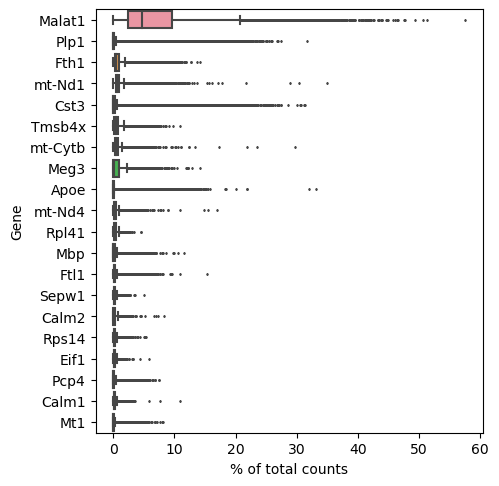

In [49]:
# genes with highest fraction of counts per cell
sc.pl.highest_expr_genes(adata, n_top=20, )

# Normalisation, logarithmization

In [50]:
adata.layers

Layers with keys: 

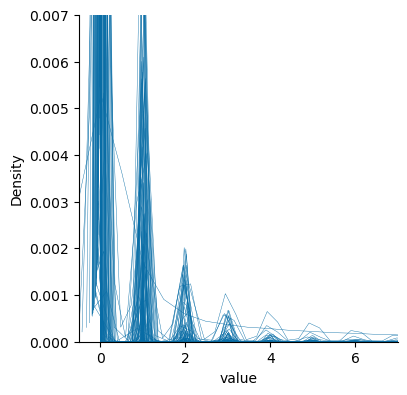

In [51]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, adata.X.shape[1]), 100)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));

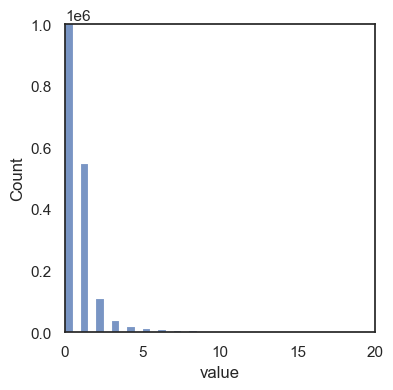

In [52]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e6));

In [53]:
adata.layers["counts"] = adata.X.copy() # save unnormalized raw RNA counts - retrieve via adata.X = adata.layers["counts"]

In [54]:
sc.pp.normalize_total(adata, inplace=True) # Normalize each spot by total counts over all genes, so that every spot has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


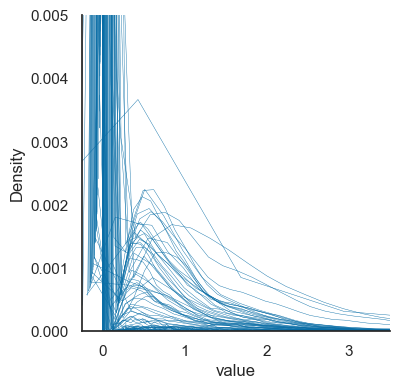

In [55]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3)
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))

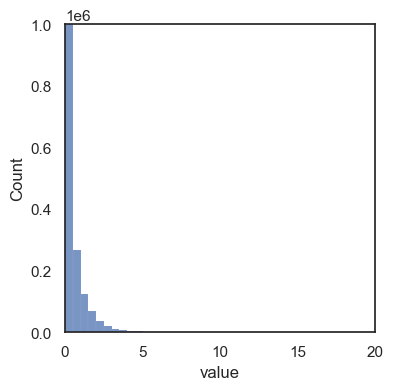

In [56]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e6));

In [57]:
sc.pp.log1p(adata) # X = log(X + 1)

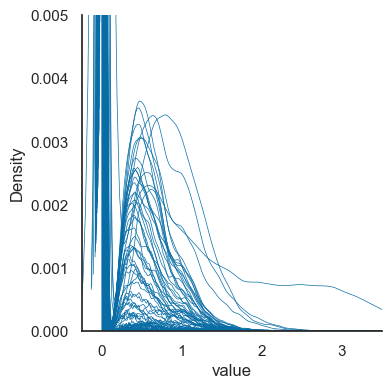

In [58]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));

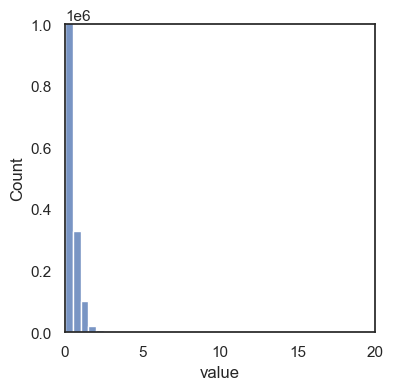

In [59]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 20),ylim=(0,1e6));

In [60]:
adata.layers["normalized"] = adata.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


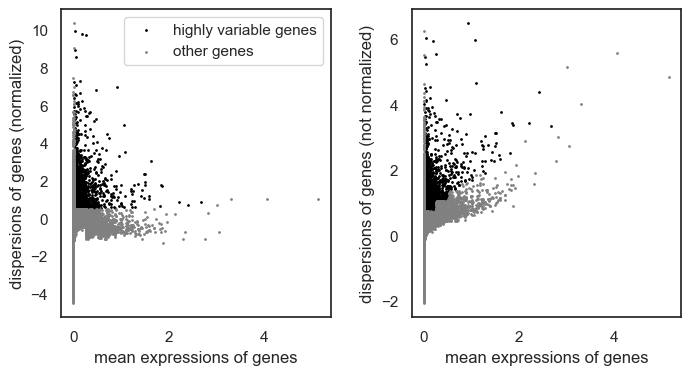

In [61]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [62]:
adata

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Taxonomy_group_colors', 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [63]:
adata.layers

Layers with keys: counts, normalized

# Dim Reduction

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)


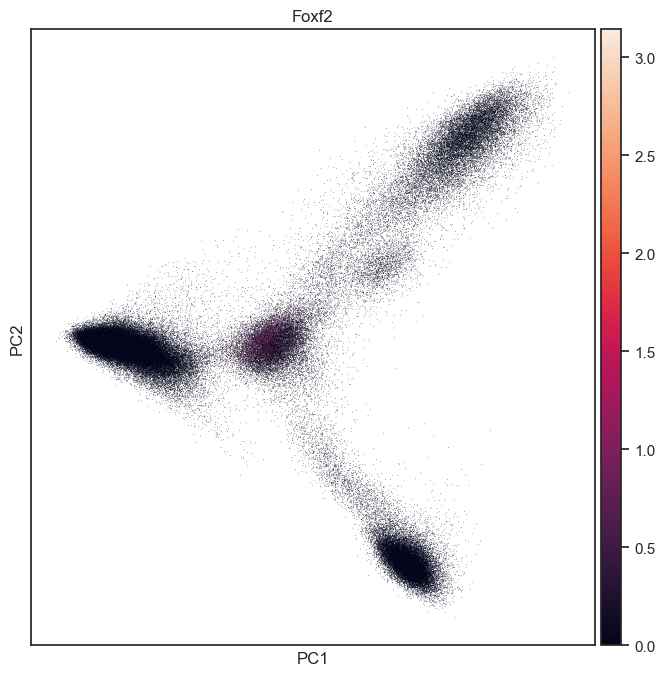

In [64]:
# Run PCA
with rc_context({'figure.figsize': (8, 8)}):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata, color='Foxf2')

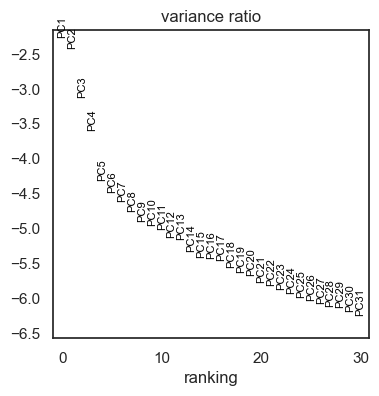

In [65]:
sc.pl.pca_variance_ratio(adata, log=True)

In [66]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:25)


In [67]:
# Run UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:15)


In [68]:
list(adata.obs.columns)

['Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study']

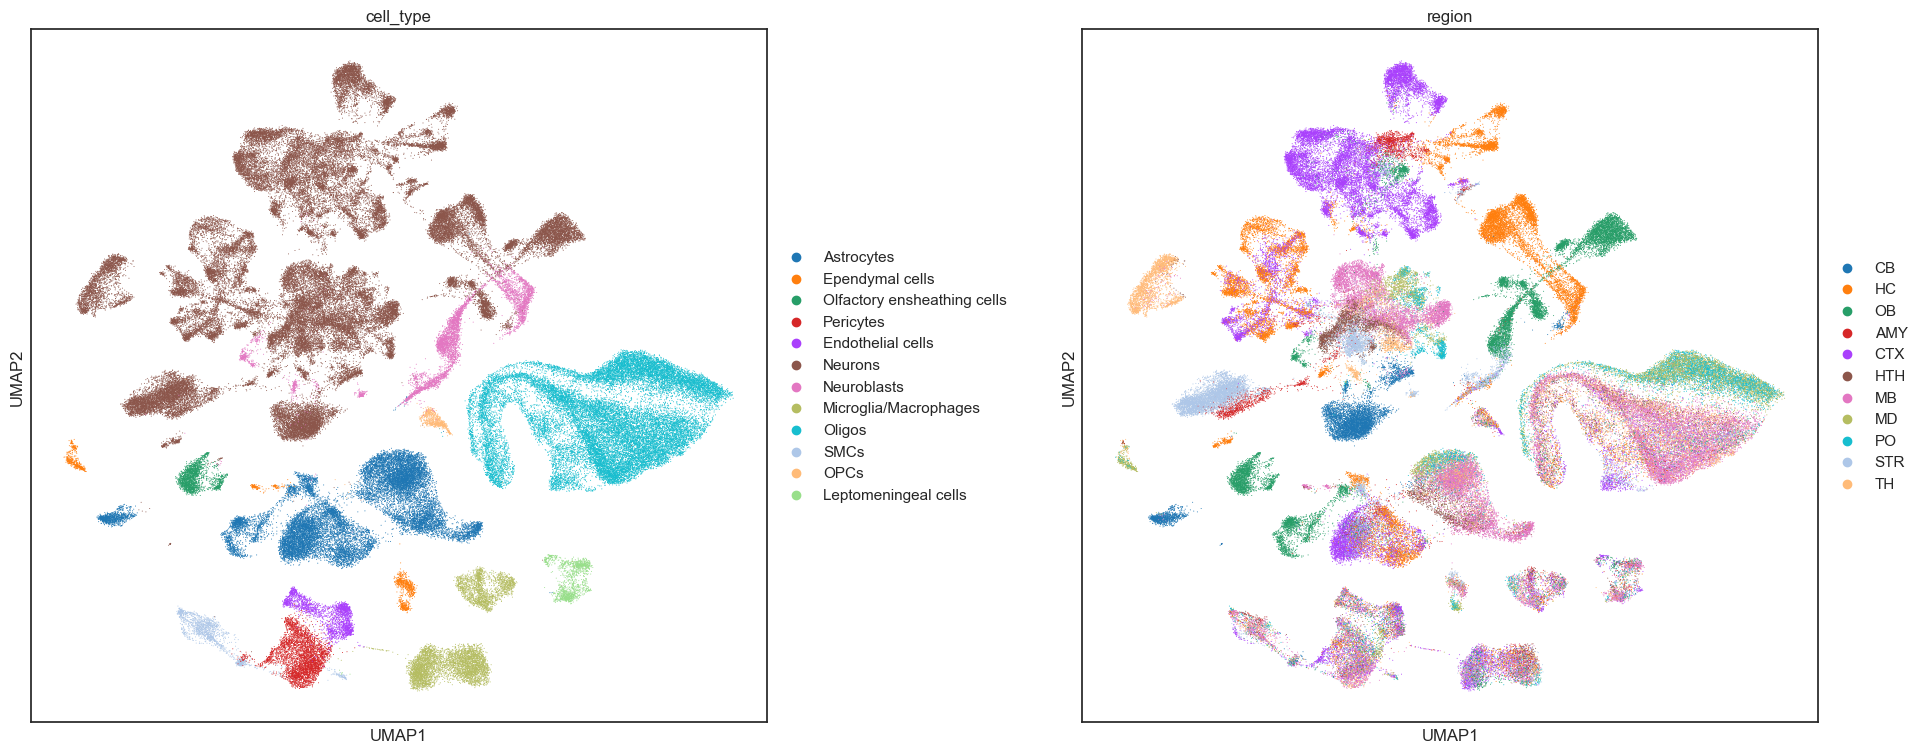

In [69]:
with rc_context({'figure.figsize': (9, 9)}):
    sc.pl.umap(adata, color=['cell_type', 'region'], wspace=0.3, size=2)

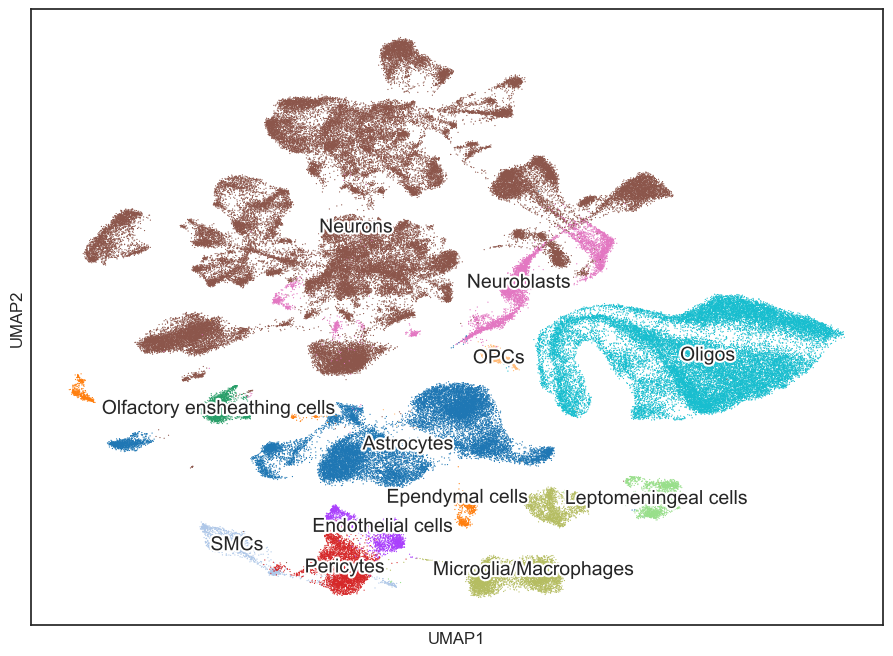

In [70]:
plt.rcParams['figure.figsize'] = [11, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=3, legend_fontsize=14, size=3)

Note: UMAP does not separate cell types very well, nonetheless stick to pre-annotated cell types

# Cell annotation

Verify annotation from authors

Manual marker gene selection

|Vascular     |EC         |Pericytes|SMCs   |Fibroblasts|Oligos|OPCs         |Ependymal|Neurons    |immature/migrating Neurons|Astrocytes|Microglia|Immune (broad/hematopoetic)|Macrophages     |Macrophages/Microglia|Monocytes|Mononcytes/B-cells|Granulocytes|B-cells|T/NK cells|
|---          |---        |---      |---    |---        |---   |---          |---      |---        |---   |---       |---      |---                        |---             |---|---|---|---|---|---|
|PDGFRA =CD140A|CLDN5      |VTN      |ACTA2  |DCN        |MBP   |CSPG4 =NG2    |PIFO     |RBFOX3 =NEUN|DCX   |AQP4      |AIF1     |PTPRC =CD45                 |CD14            |TREM2|CCR2|CD74|CD16/32|CD19|CD4|
|MCAM =CD146   |PECAM1 =CD31|PDGFRB   |MYOCD  |COL6A1     |ENPP2 |PDGFRA =CD140A|FOXJ1    |TUBB3      ||          |         |                           |ITGB2 =CD18 =CD11B||||ITGB2 =CD18 =CD11B||CD8A|
|FOXF2        |           |         |       |COL3A1     |      |             |DYNLRB2  |           ||          |         |                           |CD86            ||||CD15||CD8B|
|             |           |         |       |           |      |             |MEIG1    |           ||          |         |                           |ADGRE1 =F4/80    ||||||IL2RB|
||||||||||||||||||||IFNG|

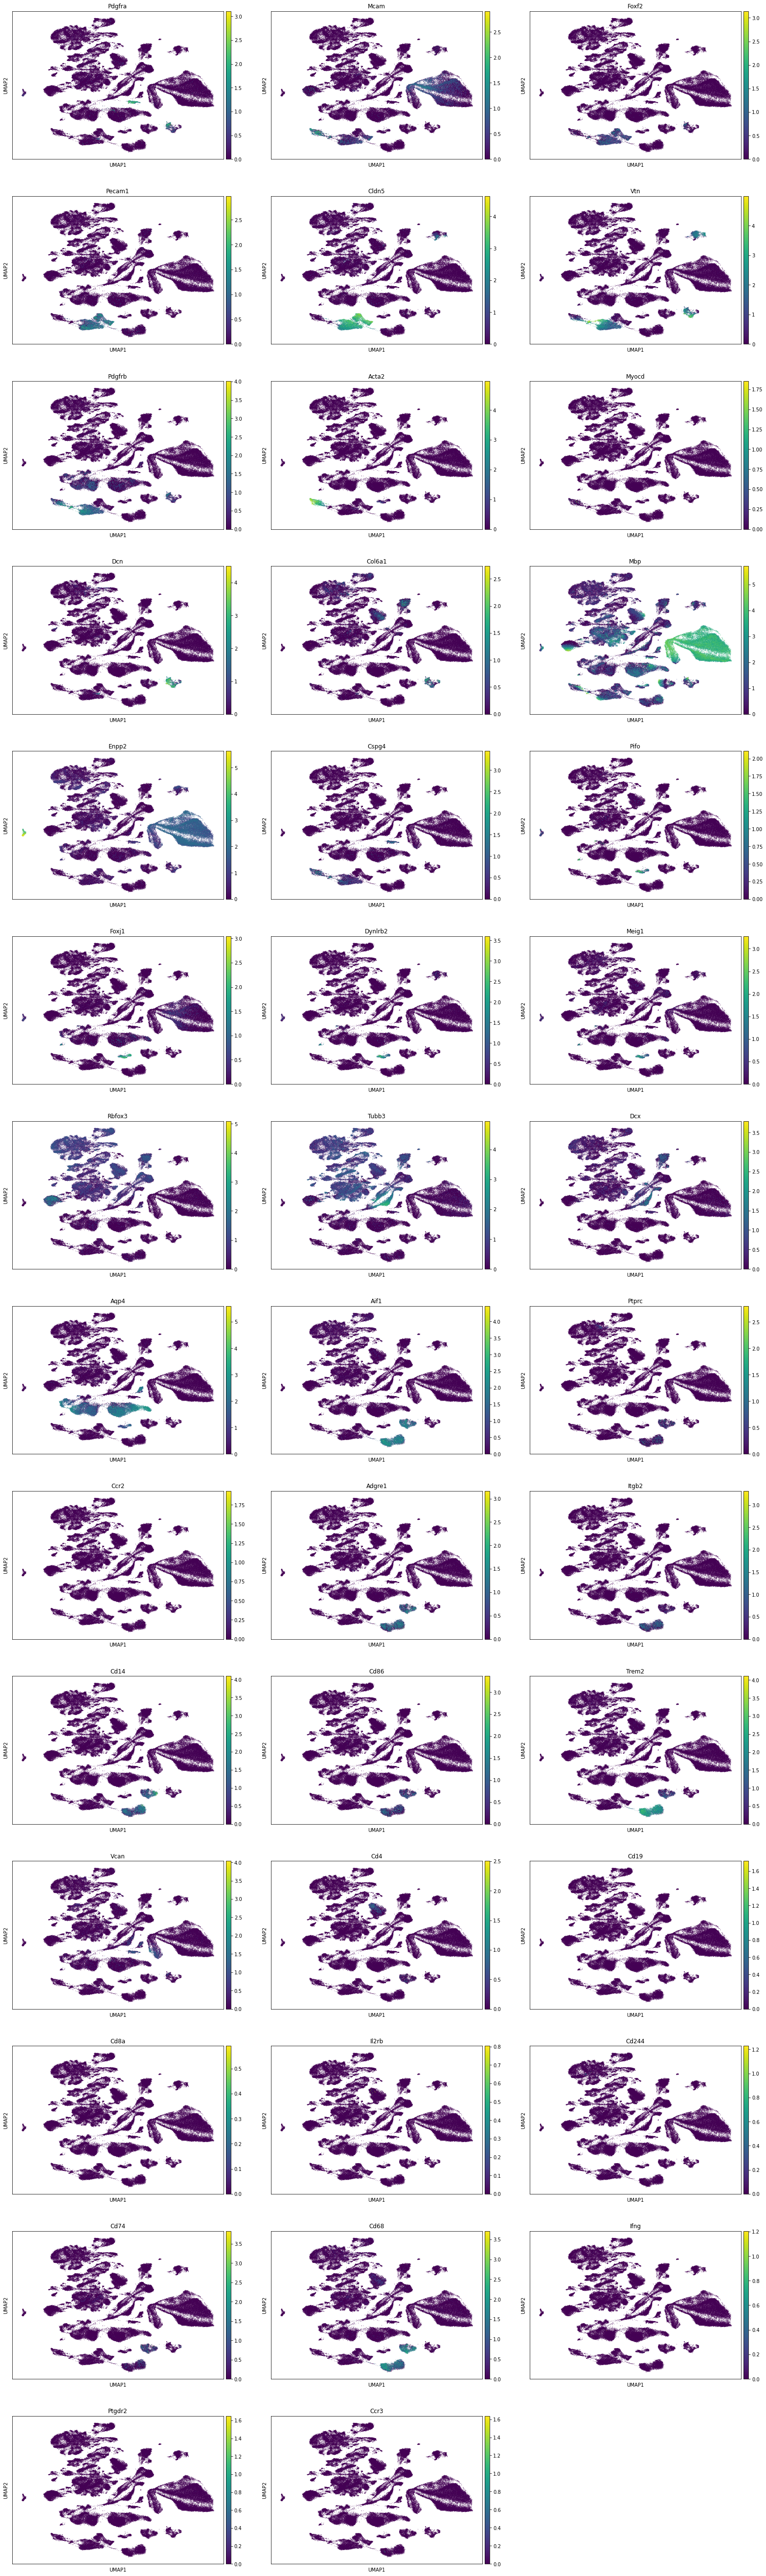

In [96]:
# plot marker genes
plt.rcParams['figure.figsize'] = [8, 6] # set plot sizes
marker_genes = ["Pdgfra", "Mcam","Foxf2", "Pecam1", "Cldn5","Vtn", "Pdgfrb","Acta2", "Myocd","Dcn", "Col6a1", "Mbp","Enpp2","Cspg4","Pifo","Foxj1","Dynlrb2","Meig1","Rbfox3","Tubb3","Dcx","Aqp4", "Aif1", "Ptprc", "Ccr2","Adgre1","Itgb2","Cd14","Cd86","Trem2","Vcan","Cd4","Cd19", "Cd8a","Il2rb","Cd244", "Cd74","Cd68","Ifng","Ptgdr2","Ccr3"]
marker_genes=[x for x in marker_genes if x in list(adata.var_names)] # remove those not in adata.var_names
sc.pl.umap(adata, ncols=3, color=marker_genes, size=3)

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:10:34)


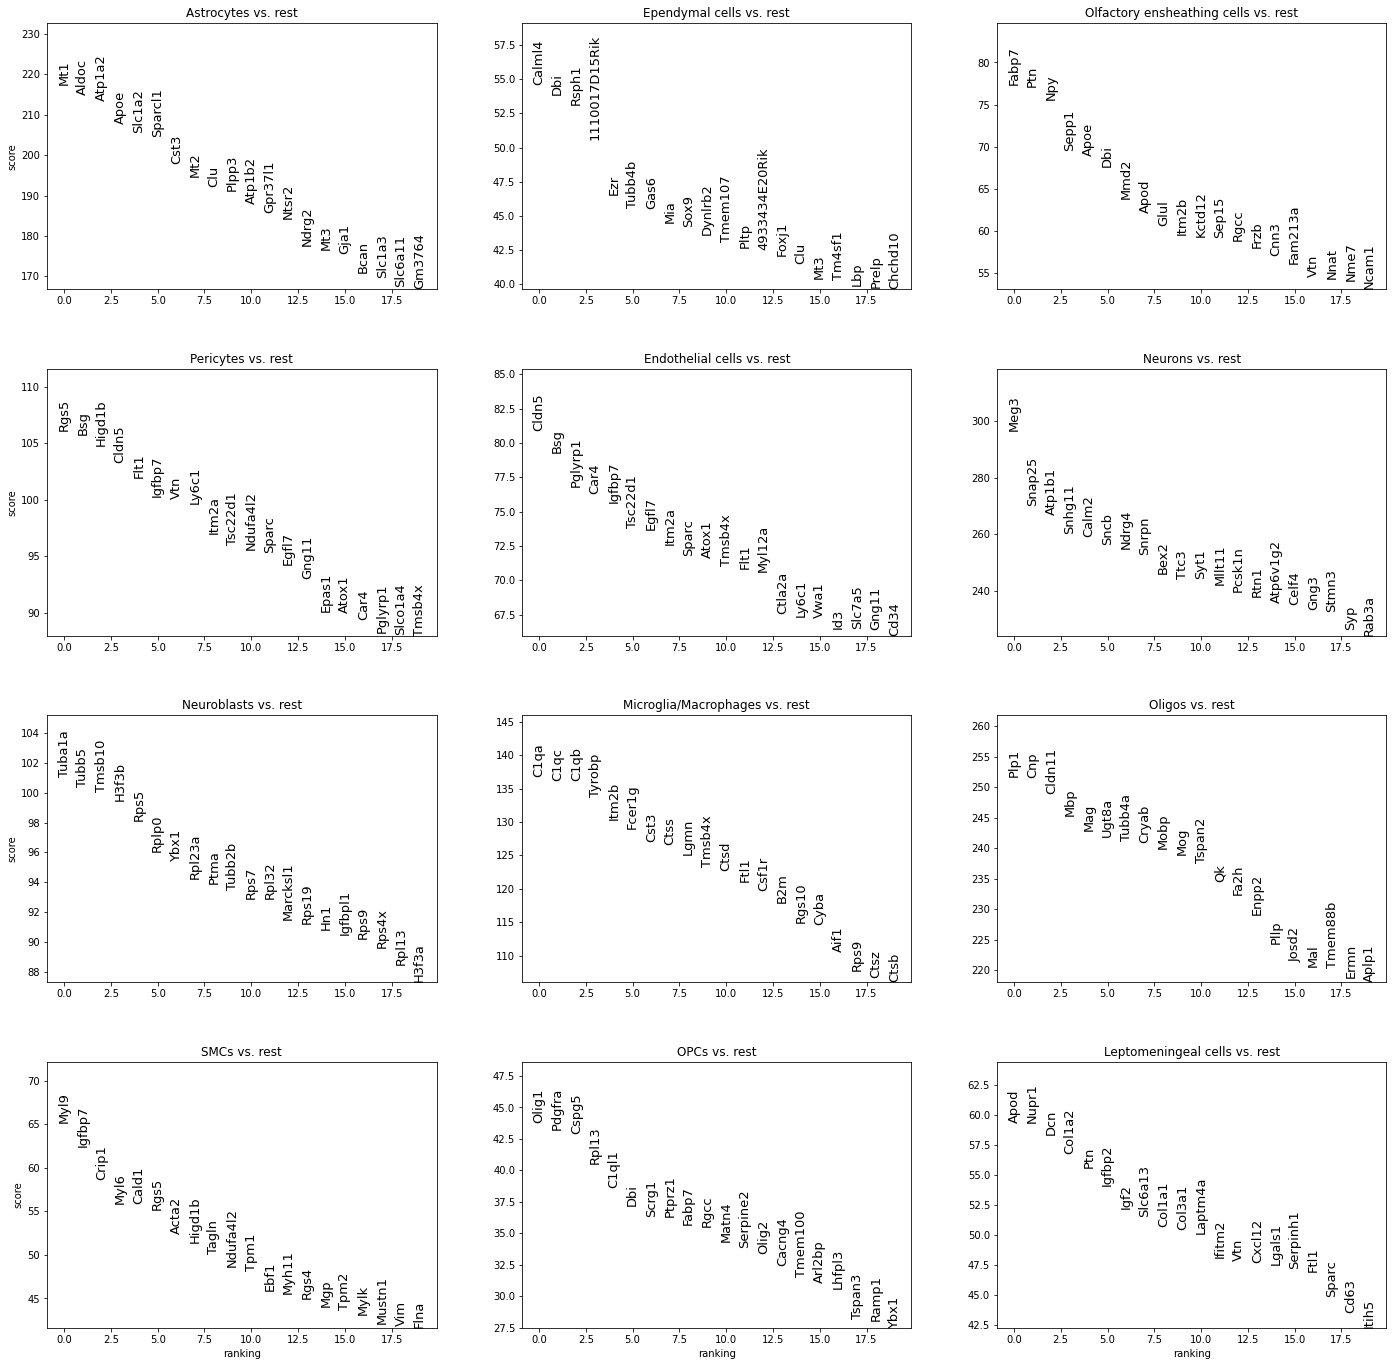

In [97]:
# Run DE test for annotation (Wilcoxon)
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon', key_added='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=3, fontsize=13, key='wilcoxon')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


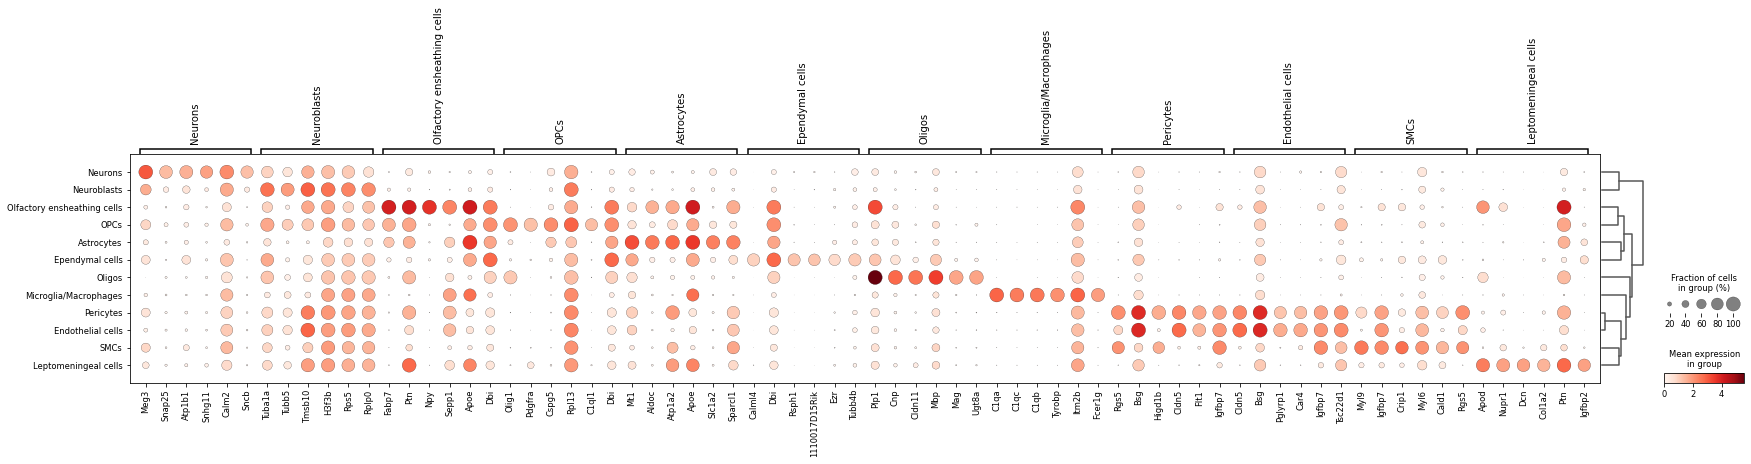

In [98]:
# Dotplot
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, key="wilcoxon", groupby="cell_type");

Note: No re-annotation required

# Focus on: Foxf2

In [101]:
adata.obs["clusters"] = adata.obs['cell_type']

In [102]:
gene="Foxf2"

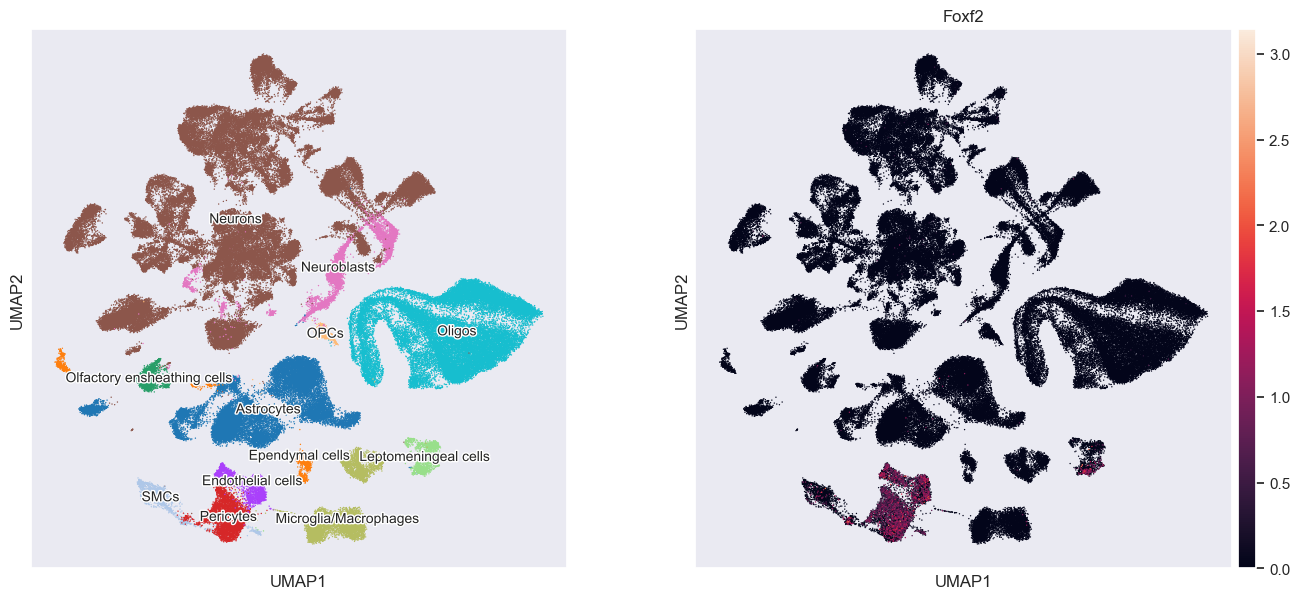

In [104]:
with rc_context({'figure.figsize': (7,7)}):
    sc.pl.umap(adata, color=['clusters',gene], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=2, legend_fontsize=10, size=4)

## Plot

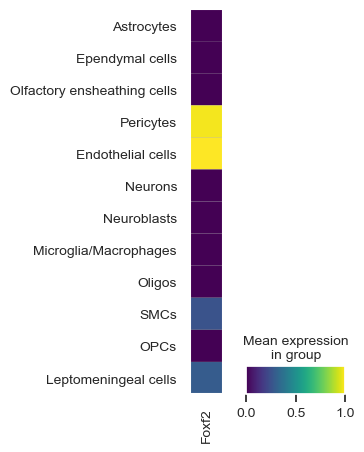

In [109]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

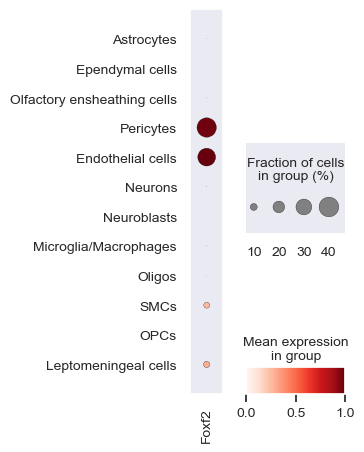

In [110]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [111]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                                    
Astrocytes                          0.002439
Ependymal cells                     0.000000
Olfactory ensheathing cells         0.002686
Pericytes                           0.983418
Endothelial cells                   1.000000
Neurons                             0.001980
Neuroblasts                         0.000000
Microglia/Macrophages               0.003101
Oligos                              0.000786
SMCs                                0.257117
OPCs                                0.000000
Leptomeningeal cells                0.288114

In [112]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                      
Astrocytes                            0.000759
Ependymal cells                       0.000000
Olfactory ensheathing cells           0.000985
Pericytes                             0.392685
Endothelial cells                     0.350471
Neurons                               0.001275
Neuroblasts                           0.000000
Microglia/Macrophages                 0.001038
Oligos                                0.000457
SMCs                                  0.080000
OPCs                                  0.000000
Leptomeningeal cells                  0.086519

In [113]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zeisel2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells   gene  \
clusters                                                                 
Astrocytes                          0.002439           0.000759  Foxf2   
Ependymal cells                     0.000000           0.000000  Foxf2   
Olfactory ensheathing cells         0.002686           0.000985  Foxf2   
Pericytes                           0.983418           0.392685  Foxf2   
Endothelial cells                   1.000000           0.350471  Foxf2   
Neurons                             0.001980           0.001275  Foxf2   
Neuroblasts                         0.000000           0.000000  Foxf2   
Microglia/Macrophages               0.003101           0.001038  Foxf2   
Oligos                              0.000786           0.000457  Foxf2   
SMCs                                0.257117           0.080000  Foxf2   
OPCs                                0.000000           0.000000  Foxf2   
Leptomeningeal cells                0.288114           0.086519  Foxf2   

                                 source organism  cell_number  
clusters                                                       
Astrocytes                   Zeisel2028    Mouse        19755  
Ependymal cells              Zeisel2028    Mouse         1419  
Olfactory ensheathing cells  Zeisel2028    Mouse         2031  
Pericytes                    Zeisel2028    Mouse         4156  
Endothelial cells            Zeisel2028    Mouse         2334  
Neurons                      Zeisel2028    Mouse        63512  
Neuroblasts                  Zeisel2028    Mouse         5466  
Microglia/Macrophages        Zeisel2028    Mouse         6744  
Oligos                       Zeisel2028    Mouse        26243  
SMCs                         Zeisel2028    Mouse         1575  
OPCs                         Zeisel2028    Mouse          733  
Leptomeningeal cells         Zeisel2028    Mouse         1491

In [114]:
# export
name='Zeisel2018'

In [115]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [116]:
gene="Foxo1"

### Plot

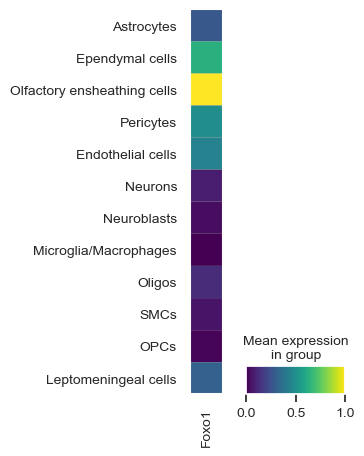

In [117]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

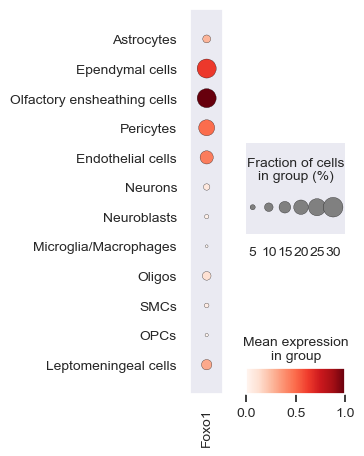

In [118]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [119]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                                    
Astrocytes                          0.269911
Ependymal cells                     0.635456
Olfactory ensheathing cells         1.000000
Pericytes                           0.492181
Endothelial cells                   0.437829
Neurons                             0.076018
Neuroblasts                         0.032349
Microglia/Macrophages               0.000000
Oligos                              0.123329
SMCs                                0.050906
OPCs                                0.008101
Leptomeningeal cells                0.307736

In [120]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                      
Astrocytes                            0.089344
Ependymal cells                       0.288231
Olfactory ensheathing cells           0.287051
Pericytes                             0.227863
Endothelial cells                     0.176949
Neurons                               0.067657
Neuroblasts                           0.039517
Microglia/Macrophages                 0.021649
Oligos                                0.100751
SMCs                                  0.043175
OPCs                                  0.027285
Leptomeningeal cells                  0.128102

In [121]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zeisel2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells   gene  \
clusters                                                                 
Astrocytes                          0.269911           0.089344  Foxo1   
Ependymal cells                     0.635456           0.288231  Foxo1   
Olfactory ensheathing cells         1.000000           0.287051  Foxo1   
Pericytes                           0.492181           0.227863  Foxo1   
Endothelial cells                   0.437829           0.176949  Foxo1   
Neurons                             0.076018           0.067657  Foxo1   
Neuroblasts                         0.032349           0.039517  Foxo1   
Microglia/Macrophages               0.000000           0.021649  Foxo1   
Oligos                              0.123329           0.100751  Foxo1   
SMCs                                0.050906           0.043175  Foxo1   
OPCs                                0.008101           0.027285  Foxo1   
Leptomeningeal cells                0.307736           0.128102  Foxo1   

                                 source organism  cell_number  
clusters                                                       
Astrocytes                   Zeisel2018    Mouse        19755  
Ependymal cells              Zeisel2018    Mouse         1419  
Olfactory ensheathing cells  Zeisel2018    Mouse         2031  
Pericytes                    Zeisel2018    Mouse         4156  
Endothelial cells            Zeisel2018    Mouse         2334  
Neurons                      Zeisel2018    Mouse        63512  
Neuroblasts                  Zeisel2018    Mouse         5466  
Microglia/Macrophages        Zeisel2018    Mouse         6744  
Oligos                       Zeisel2018    Mouse        26243  
SMCs                         Zeisel2018    Mouse         1575  
OPCs                         Zeisel2018    Mouse          733  
Leptomeningeal cells         Zeisel2018    Mouse         1491

In [122]:
# export
name='Zeisel2018'

In [123]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

## Tek = Tie2

In [124]:
gene="Tek"

### Plot

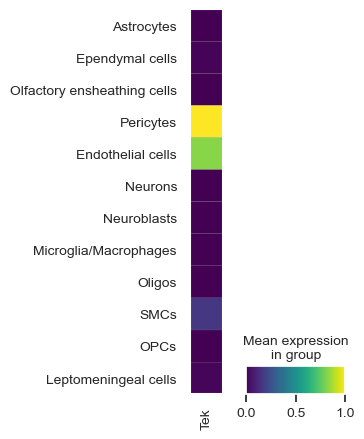

In [125]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

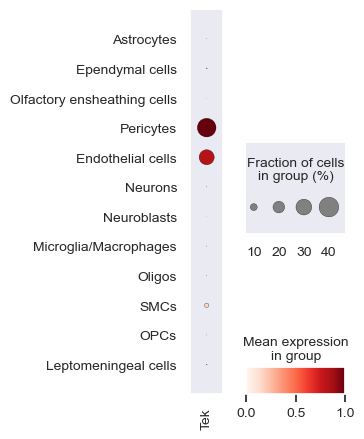

In [126]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [127]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                                    
Astrocytes                          0.002218
Ependymal cells                     0.011373
Olfactory ensheathing cells         0.000000
Pericytes                           1.000000
Endothelial cells                   0.820371
Neurons                             0.001456
Neuroblasts                         0.000221
Microglia/Macrophages               0.003251
Oligos                              0.001421
SMCs                                0.159746
OPCs                                0.002336
Leptomeningeal cells                0.014918

In [128]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                      
Astrocytes                            0.001063
Ependymal cells                       0.007047
Olfactory ensheathing cells           0.000492
Pericytes                             0.374158
Endothelial cells                     0.280634
Neurons                               0.002031
Neuroblasts                           0.000549
Microglia/Macrophages                 0.001631
Oligos                                0.001715
SMCs                                  0.053968
OPCs                                  0.001364
Leptomeningeal cells                  0.005366

In [129]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zeisel2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells gene  \
clusters                                                               
Astrocytes                          0.002218           0.001063  Tek   
Ependymal cells                     0.011373           0.007047  Tek   
Olfactory ensheathing cells         0.000000           0.000492  Tek   
Pericytes                           1.000000           0.374158  Tek   
Endothelial cells                   0.820371           0.280634  Tek   
Neurons                             0.001456           0.002031  Tek   
Neuroblasts                         0.000221           0.000549  Tek   
Microglia/Macrophages               0.003251           0.001631  Tek   
Oligos                              0.001421           0.001715  Tek   
SMCs                                0.159746           0.053968  Tek   
OPCs                                0.002336           0.001364  Tek   
Leptomeningeal cells                0.014918           0.005366  Tek   

                                 source organism  cell_number  
clusters                                                       
Astrocytes                   Zeisel2018    Mouse        19755  
Ependymal cells              Zeisel2018    Mouse         1419  
Olfactory ensheathing cells  Zeisel2018    Mouse         2031  
Pericytes                    Zeisel2018    Mouse         4156  
Endothelial cells            Zeisel2018    Mouse         2334  
Neurons                      Zeisel2018    Mouse        63512  
Neuroblasts                  Zeisel2018    Mouse         5466  
Microglia/Macrophages        Zeisel2018    Mouse         6744  
Oligos                       Zeisel2018    Mouse        26243  
SMCs                         Zeisel2018    Mouse         1575  
OPCs                         Zeisel2018    Mouse          733  
Leptomeningeal cells         Zeisel2018    Mouse         1491

In [130]:
# export
name='Zeisel2018'

In [131]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

## Nos3 = eNOS

In [132]:
gene="Nos3"

### Plot

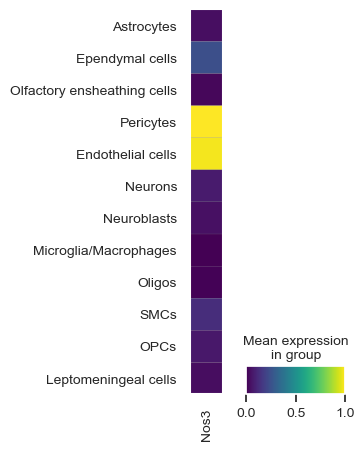

In [133]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

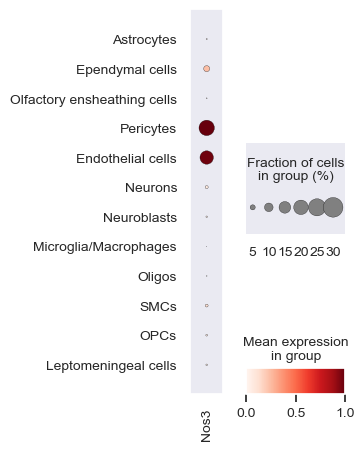

In [134]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [135]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                                    
Astrocytes                          0.038204
Ependymal cells                     0.238638
Olfactory ensheathing cells         0.018281
Pericytes                           1.000000
Endothelial cells                   0.981928
Neurons                             0.074136
Neuroblasts                         0.039580
Microglia/Macrophages               0.000000
Oligos                              0.006117
SMCs                                0.125381
OPCs                                0.065956
Leptomeningeal cells                0.034024

In [136]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                      
Astrocytes                            0.006581
Ependymal cells                       0.062016
Olfactory ensheathing cells           0.004431
Pericytes                             0.216795
Endothelial cells                     0.180377
Neurons                               0.024704
Neuroblasts                           0.010062
Microglia/Macrophages                 0.001335
Oligos                                0.003772
SMCs                                  0.022857
OPCs                                  0.012278
Leptomeningeal cells                  0.010731

In [137]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zeisel2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells  gene  \
clusters                                                                
Astrocytes                          0.038204           0.006581  Nos3   
Ependymal cells                     0.238638           0.062016  Nos3   
Olfactory ensheathing cells         0.018281           0.004431  Nos3   
Pericytes                           1.000000           0.216795  Nos3   
Endothelial cells                   0.981928           0.180377  Nos3   
Neurons                             0.074136           0.024704  Nos3   
Neuroblasts                         0.039580           0.010062  Nos3   
Microglia/Macrophages               0.000000           0.001335  Nos3   
Oligos                              0.006117           0.003772  Nos3   
SMCs                                0.125381           0.022857  Nos3   
OPCs                                0.065956           0.012278  Nos3   
Leptomeningeal cells                0.034024           0.010731  Nos3   

                                 source organism  cell_number  
clusters                                                       
Astrocytes                   Zeisel2018    Mouse        19755  
Ependymal cells              Zeisel2018    Mouse         1419  
Olfactory ensheathing cells  Zeisel2018    Mouse         2031  
Pericytes                    Zeisel2018    Mouse         4156  
Endothelial cells            Zeisel2018    Mouse         2334  
Neurons                      Zeisel2018    Mouse        63512  
Neuroblasts                  Zeisel2018    Mouse         5466  
Microglia/Macrophages        Zeisel2018    Mouse         6744  
Oligos                       Zeisel2018    Mouse        26243  
SMCs                         Zeisel2018    Mouse         1575  
OPCs                         Zeisel2018    Mouse          733  
Leptomeningeal cells         Zeisel2018    Mouse         1491

In [138]:
# export
name='Zeisel2018'

In [139]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

# Save

In [140]:
adata

AnnData object with n_obs × n_vars = 135459 × 27998
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type', 'study', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Taxonomy_group_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'region_colors', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [141]:
name='zeisel_normalised_logarithmised_annotated'

In [143]:
# Win
adata.write(main_dir+"\P6_Foxf2_per_celltype\\scRNAseq\\" + date.today().strftime("%Y%m%d")+'_'+name+'.h5ad')

In [ ]:
# Linux: writing to mounted drive causes error. save locally then move.
os.chdir('/home/simon/Downloads')
ad_sc.write(date.today().strftime("%Y%m%d")+'_'+name+'.h5ad')

# Session Info

In [144]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.3.0
h5py                        3.6.0
hypergeom_ufunc             NA
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.7.0
jedi                        0.18.1
jinja2 